In [1]:
%set_env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from alibi.explainers.similarity.grad import GradientSimilarity

## Load data

Loading and preparing the MNIST data set.

In [3]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test
test_labels = y_test.copy()
train_labels = y_train.copy()
                         
X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


## Train model

Train a convolutional neural network on the MNIST dataset. The model includes 2 convolutional layers and it reaches a test accuracy of 0.98. If `save_model = True`, a local folder `./model_mnist` will be created and the trained model will be saved in that folder. If the model was previously saved, it can be loaded by setting `load_mnist_model = True`.

In [4]:
load_mnist_model = True
save_model = True

In [5]:
filepath = './model_mnist/'  # change to directory where model is saved
if load_mnist_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=6,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    if save_model:
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        model.save(os.path.join(filepath, 'model.h5'))

2022-04-25 11:56:42.728959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 11:56:42.735642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 11:56:42.736601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 11:56:42.737880: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Find similaraties 

In [6]:
model.loss

<function keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)>

In [7]:
categorical_crossentropy(model(X_sample), y_sample)

NameError: name 'X_sample' is not defined

In [25]:
!git branch 

* feature/similarity-explainers
  intgrads-select-target
  master


In [9]:
gsm = GradientSimilarity(model, model.loss)

In [10]:
gsm.fit(X_train, y_train)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_dot',
              'store_grads': False,
              'backend_name': 'tensorflow',
              'task_name': 'classification'}
            ,
  'version': '0.6.6dev'}
)

In [14]:
X_sample, y_sample = X_test[:1], y_test[:1]
X_sample.shape

(1, 28, 28, 1)

In [ ]:
gsm.explain(X_sample, y_sample)

In [12]:
np.expand_dims(X_sample[0], axis=0).shape

(1, 28, 28, 1)

In [23]:
explanations = []
for i in range(X_sample.shape[0]):
    x, y = np.expand_dims(X_sample[i], axis=0), y_sample[i]
    exp = gsm.explain(x, y)
    explanations.append(exp)


KeyboardInterrupt



In [ ]:
gsm.X_dims

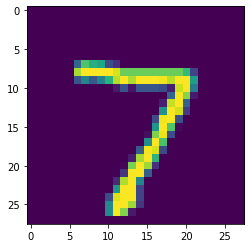

In [11]:
plt.imshow(X_sample[0])

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.


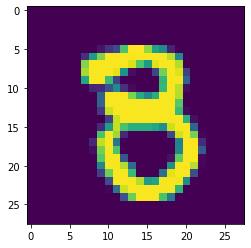

In [12]:
plt.imshow(exps['data']['most_similar'][0])

## Most similar labels distributions 

In [18]:
exps.data['most_similar'].shape

(5, 28, 28, 1)

In [34]:
exps['ordered_indices']

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.


array([40829, 15450, 47690, ..., 39184, 43109,  6848])

In [40]:
y_train[exps['ordered_indices'][4]]

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.


array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [36]:
y_sample[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)